In [1]:
import time
import torch
import numpy as np
from numba import jit
import networkx as nx
from matplotlib import pyplot as plt

plt.style.use('dark_background')

In [2]:
from abc import abstractmethod

class BaseLabelPropagation:
    '''Base class for label propagation models.
    
    Parameters
    ----------
    adj_matrix: torch.FloatTensor
        Adjacency matrix of the graph.
    '''
    def __init__(self, adj_matrix):
        self.norm_adj_matrix = self._normalize(adj_matrix)
        self.n_nodes = adj_matrix.size(0)
        self.one_hot_labels = None 
        self.n_classes = None
        self.labeled_mask = None
        self.predictions = None

    @staticmethod
    @abstractmethod
    def _normalize(adj_matrix):
        raise NotImplementedError('_normalize must be implemented')

    @abstractmethod
    def _propagate(self):
        raise NotImplementedError('_propagate must be implemented')

    def _one_hot_encode(self, labels):        
        # Get the number of classes
        classes = torch.arange(0, 11, device=labels.device)
        classes = classes[classes != -1]
        self.n_classes = classes.size(0)

        # One-hot encode labeled data instances and zero rows corresponding to unlabeled instances
        unlabeled_mask = (labels == -1)
        #labels = labels.clone()  # defensive copying
        labels[unlabeled_mask] = 0
        self.one_hot_labels = torch.zeros((self.n_nodes, self.n_classes), dtype=torch.float, device=labels.device)
        
        self.one_hot_labels = self.one_hot_labels.scatter(1, labels.unsqueeze(1), 1)
        self.one_hot_labels[unlabeled_mask, 0] = 0

        self.labeled_mask = ~unlabeled_mask

    def fit(self, labels, max_iter, tol, verbose=True):
        '''Fits a semi-supervised learning label propagation model.
        
        labels: torch.LongTensor
            Tensor of size n_nodes indicating the class number of each node.
            Unlabeled nodes are denoted with -1.
        max_iter: int
            Maximum number of iterations allowed.
        tol: float
            Convergence tolerance: threshold to consider the system at steady state.
        '''
        self._one_hot_encode(labels)

        self.predictions = self.one_hot_labels.clone()
        prev_predictions = torch.zeros((self.n_nodes, self.n_classes), dtype=torch.float, device=labels.device)

        for i in range(max_iter):
            # Stop iterations if the system is considered at a steady state
            variation = torch.abs(self.predictions - prev_predictions).sum().item()
            
            if variation < tol:
                if verbose:
                    print(f'The method stopped after {i} iterations, variation={variation:.4f}.')
                break

            prev_predictions = self.predictions.clone()
            self._propagate()

    def predict(self):
        return self.predictions

    def predict_classes(self):
        return self.predictions.max(dim=1).indices

In [3]:
class LabelSpreading(BaseLabelPropagation):
    def __init__(self, adj_matrix):
        super().__init__(adj_matrix)
        self.alpha = None

    @staticmethod
    def _normalize(adj_matrix):
        '''Computes D^-1/2 * W * D^-1/2'''
        degs = adj_matrix.sum(dim=1)
        norm = torch.pow(degs, -0.5)
        norm[torch.isinf(norm)] = 1
        return adj_matrix * norm[:, None] * norm[None, :]

    def _propagate(self):
        self.predictions = (
            self.alpha * torch.matmul(self.norm_adj_matrix, self.predictions)
            + (1 - self.alpha) * self.one_hot_labels
        )
        #self.predictions[self.labeled_mask] = self.one_hot_labels[self.labeled_mask]
    
    def fit(self, labels, max_iter=1000, tol=1e-3, alpha=0.5, verbose=True):
        '''
        Parameters
        ----------
        alpha: float
            Clamping factor.
        '''
        self.alpha = alpha
        super().fit(labels, max_iter, tol, verbose)

In [4]:
from joblib import Parallel, delayed


@jit(nopython=True)
def process_weight_matrix(W):
    row_sums = W.sum(axis=1)
    W /= row_sums[:, np.newaxis]

    n = W.shape[0]
    for i in range(n):
        for j in range(n):
            if i != j:
                W[i, j] = max(W[i, j], W[j, i])
    return W


@jit(nopython=True)
def generate_weight_matrix(n, p):
    W = np.zeros(shape=(n, n), dtype=np.float32)

    for i in range(n):
        for j in range(i + 1, n):
            if np.random.uniform(0, 1) <= p:
                W[i, j] = W[j, i] = 1.0

    W = process_weight_matrix(W)
    return W


def initialize_population(population_len, n, p_range, n_jobs=-1, rng_seed=42):
    np.random.seed(rng_seed)

    population = Parallel(n_jobs=n_jobs)(
        delayed(generate_weight_matrix)(n, np.random.uniform(*p_range)) for _ in range(population_len)
    )
    return population


In [5]:
def get_test_indices(data, test_size=0.3, rng_seed=42):
    np.random.seed(rng_seed)

    test_indices = []

    for movie in data:
        non_zero_indices = np.nonzero(movie)[0]

        test_sample_size = int(test_size * len(non_zero_indices))
        random_indices = np.random.choice(non_zero_indices, size=test_sample_size, replace=False)        
        test_indices.append(random_indices)
        # print(f'{len(random_indices)=}')
    
    return test_indices


def run_label_spreading(W, original_data, predicted_data, test_indices, alpha=0.8, verbose=True):
    adj_matrix_t = torch.FloatTensor(W)

    for i in range(original_data.shape[0]):
        labels_t = torch.LongTensor( original_data[i, :W.shape[0]] )    # might need to make a copy of original_data for warning suppression
        
        if len(test_indices[i]):
            labels_t[test_indices[i]] = 0
        
        labels_t[labels_t == 0] = -1
            
        label_spreading = LabelSpreading(adj_matrix_t)
        label_spreading.fit(labels_t, alpha=alpha, verbose=verbose)
        label_spreading_output_labels = label_spreading.predict_classes()

        predicted_data[i, :] = label_spreading_output_labels


@jit(nopython=True)
def mean_absolute_error(y_true, y_pred, denom):
    return np.sum(np.abs(y_true - y_pred)) / denom


@jit(nopython=True)
def mean_squared_error(y_true, y_pred, denom):
    return np.sum((y_true - y_pred) ** 2) / denom


def get_fitness(original_data, predicted_data, test_indices):
    e = []

    for i in range(original_data.shape[0]):
        if len(test_indices[i]):
            y_true = original_data[i, test_indices[i]].astype(np.int8)
            y_pred = predicted_data[i, test_indices[i]].astype(np.int8)
            # mae = mean_absolute_error(y_true, y_pred, len(original_data[i, :]) - np.count_nonzero(original_data[i, :]))
            mse = mean_squared_error(y_true, y_pred, np.count_nonzero(original_data[i, :]))
            e.append(mse)
        else:
            raise Exception('empty test sample')
                
    return np.sum(e) / original_data.shape[0]


def evaluate_population(population, original_data, test_indices, verbose=True):
    scores = [ [i, None, None] for i in range(len(population)) ] 
    
    # for i in range(len(test_indices)):
    #     print(f'{len(test_indices[i])=}', end=' ')
    
    for i in range(len(population)):
        # print(f'individual: {i}')
        predicted_data = np.empty_like(original_data)
        run_label_spreading(population[i], original_data, predicted_data, test_indices, verbose=verbose)
        scores[i][1] = -get_fitness(original_data, predicted_data, test_indices)
        scores[i][2] = predicted_data
        
    return scores

In [ ]:
import random

def blend_crossover(W1, W2, alpha=0.5):
    min_vals = np.minimum(W1, W2)
    max_vals = np.maximum(W1, W2)
    range_vals = alpha * (max_vals - min_vals)

    lower_bound = min_vals - range_vals
    upper_bound = max_vals + range_vals

    return process_weight_matrix(np.random.uniform(lower_bound, upper_bound, size=W1.shape))

@jit(nopython=True)
def weighted_blend_crossover(W1, W2, W1_fitness, W2_fitness, alpha=0.5):
    fitness_W1 = W1_fitness
    fitness_W2 = W2_fitness
    adjusted_alpha = alpha * (fitness_W1 / (fitness_W1 + fitness_W2))

    min_vals = np.minimum(W1, W2)
    max_vals = np.maximum(W1, W2)
    range_vals = adjusted_alpha * (max_vals - min_vals)

    lower_bound = min_vals - range_vals
    upper_bound = max_vals + range_vals

    return process_weight_matrix(np.random.uniform(lower_bound, upper_bound, size=W1.shape))


@jit(nopython=True)
def crossover(W1, W2):
    new_W = np.clip((W1 + W2) / 2, 0., 1.)
    return process_weight_matrix(new_W)


def elitist_selection(scores, elite_percentage):
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    elite_size = int(len(scores) * elite_percentage)
    elites_indices = [ scores[i][0]  for i in range(elite_size) ]
    return elites_indices


def tournament_selection(scores, elite_indices, num_parents, tournament_size):
    parents_indices = elite_indices.copy()

    cnt = 0
    while len(parents_indices) - len(elite_indices) < num_parents:
        tournament_indices = random.sample(list(set(range(len(scores))) - set(parents_indices)), tournament_size)

        tournament_scores = [ (i, scores[i][1]) for i in tournament_indices ]
        winner_idx = max(tournament_scores, key=lambda x: x[1])[0]

        if winner_idx not in parents_indices:
            parents_indices.append(winner_idx)
            cnt = 0
        else:
            cnt += 1
            if cnt == 10:
                raise Exception('could not find another parent')
    
    return parents_indices 


def mutate_matrix(W, mutation_rate, mutation_range):
    mutated_matrix = np.copy(W)
    rows, cols = mutated_matrix.shape
    num_mutations = int(np.ceil(mutation_rate * rows * cols))

    mutation_indices = np.random.randint(0, rows * cols, num_mutations)
    row_indices = mutation_indices // cols
    col_indices = mutation_indices % cols

    mutation_values = np.random.uniform(*mutation_range, num_mutations)

    np.add.at(mutated_matrix, (row_indices, col_indices), mutation_values)
    np.clip(mutated_matrix, 0.0, 1.0, out=mutated_matrix)

    row_sums = mutated_matrix.sum(axis=1, keepdims=True)
    mutated_matrix /= row_sums
    mutated_matrix = (mutated_matrix + mutated_matrix.T) / 2

    return mutated_matrix

In [148]:
import os
import psutil

memory_gb = psutil.virtual_memory().total / 1024**3
print(f'{memory_gb=}')

num_users = int(1000)
print(f'{num_users=}')

num_items = 18
print(f'{num_items=}')

num_cpus = os.cpu_count()
print(f'{num_cpus=}')

partitions = num_cpus - 1
population_len = 30
print(f'{partitions=}, {population_len=}')
p_range = (0.1, 0.3)

memory_gb=47.83592224121094
num_users=1000
num_items=18
num_cpus=16
partitions=15, population_len=30


In [149]:
def create_sparse_matrix(n, m, zero_percentage, rng_seed=42):
    np.random.seed(rng_seed)  

    total_elements = n * m
    num_zeros = int(zero_percentage * total_elements)
    num_non_zeros = total_elements - num_zeros

    elements = np.concatenate((np.zeros(num_zeros, dtype=int), np.random.randint(1, 11, num_non_zeros)))
    np.random.shuffle(elements)

    sparse_matrix = np.reshape(elements, (n, m))

    return sparse_matrix

In [150]:
original_data = create_sparse_matrix(num_items, num_users, 0.2)

In [151]:
np.count_nonzero(original_data) / original_data.size * 100

80.0

In [152]:
# original_data = D.copy()[:num_users, :].T
# original_data.shape

In [153]:
(12 + 7) // 2

9

In [157]:
0.3 * 30

9.0

In [165]:
epochs = 50
hist = np.zeros(shape=(epochs, 2), dtype=np.float64)

test_indices = get_test_indices(original_data, test_size=0.4)
population = initialize_population(population_len=population_len, n=num_users, p_range=p_range)

for i in range(epochs):
    scores = evaluate_population(population, original_data, test_indices, verbose=False)
    valid_scores = [x for x in scores if x[1] != np.finfo(float).max]
    
    average_fitness = sum(x[1] for x in valid_scores) / len(valid_scores)
    best_fitness = max(valid_scores, key=lambda x:x[1])[1]
    print(f'{i}: {average_fitness=}, best_fitness={best_fitness}')

    elites_indices = elitist_selection(scores, 0.5)
    parents_indices = tournament_selection(scores, elites_indices, population_len // 4, int(0.3 * population_len))
    random.shuffle(parents_indices)

    parent_pairs = [(parents_indices[i], parents_indices[i + 1]) for i in range(0, len(parents_indices) - 1, 2)]    
    new_population = [ weighted_blend_crossover(population[pair[0]], population[pair[1]], scores[pair[0]][1], scores[pair[1]][1], alpha=0.1) for pair in parent_pairs ]

    diff = population_len - len(new_population) - len(parents_indices)
    if diff > 0:
        for _ in range(diff):
            new_population.append(population[random.choice(range(population_len))])

    new_population = [ mutate_matrix(individual, mutation_rate=0.1, mutation_range=(-0.006, 0.006)) for individual in new_population ]
    new_population.extend([ population[i] for i in parents_indices ])
    population = new_population
    
    # print(f'\t{len(elites_indices)=}, {len(parents_indices)=}, {len(parent_pairs)=}, {len(population)=}')
    hist[i][0] = average_fitness
    hist[i][1] = best_fitness

0: average_fitness=-27.564382716049376, best_fitness=-24.8510582010582
1: average_fitness=-26.844219977553312, best_fitness=-24.8510582010582
2: average_fitness=-26.616262060379707, best_fitness=-24.8510582010582
3: average_fitness=-26.31463109935332, best_fitness=-24.8510582010582
4: average_fitness=-26.13552838552838, best_fitness=-24.8510582010582
5: average_fitness=-26.157264407264407, best_fitness=-24.8510582010582
6: average_fitness=-25.932632632632636, best_fitness=-24.8026455026455
7: average_fitness=-25.833411983411985, best_fitness=-24.8026455026455
8: average_fitness=-25.802609752609754, best_fitness=-24.8026455026455
9: average_fitness=-25.916945516945518, best_fitness=-24.8026455026455
10: average_fitness=-25.851737451737453, best_fitness=-24.8026455026455
11: average_fitness=-25.731860431860433, best_fitness=-24.8026455026455
12: average_fitness=-25.536600886600887, best_fitness=-24.563227513227513
13: average_fitness=-25.541291291291287, best_fitness=-24.563227513227513


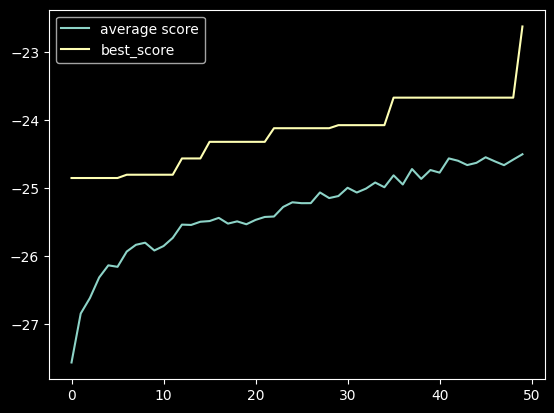

In [166]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), hist[:epochs, :epochs])
plt.legend(['average score', 'best_score'])
plt.savefig('gen_algo_res')
plt.show()